In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing

In [38]:
d= {'col1':["Hello I am here. I am not here!!!!"]}
train = pd.DataFrame(data = d)
train

,col1
0,Hello I am here. I am not here!!!!


In [39]:
train['text length'] = train['col1'].str.len()
train['num capital letters'] = train['col1'].str.count(r'[A-Z]')
train['num punctuation'] = train['col1'].str.count(r'[^\w\s]')
train['num words'] = train['col1'].str.split().str.len()
train['smiley faces'] = train['col1'].str.contains('|'.join(["(:\)|:\(|:-\)|:-\()[^A-Za-z0-9]+",":D","D:"]))



/tmp/ipykernel_2921984/968426975.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  train['smiley faces'] = train['col1'].str.contains('|'.join(["(:\)|:\(|:-\)|:-\()[^A-Za-z0-9]+",":D","D:"]))


In [40]:
train.head(3)

,col1,text length,num capital letters,num punctuation,num words,smiley faces
0,Hello I am here. I am not here!!!!,34,3,5,8,False


In [61]:
df = pd.read_csv('./train.csv')
df.head(3)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0


In [62]:
df['text length'] = df['question_text'].str.len()
df['num capital letters'] = df['question_text'].str.count(r'[A-Z]')
df['num punctuation'] = df['question_text'].str.count(r'[^\w\s]')
df['num words'] = df['question_text'].str.split().str.len()
df['smiley faces'] = df['question_text'].str.contains('|'.join(["(:\)|:\(|:-\)|:-\()[^A-Za-z0-9]+",":D","D:"]))

/tmp/ipykernel_2921984/1646185303.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['smiley faces'] = df['question_text'].str.contains('|'.join(["(:\)|:\(|:-\)|:-\()[^A-Za-z0-9]+",":D","D:"]))


In [63]:
X = df.drop(['question_text','qid'],axis=1)
y = df.target
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=1000)


In [57]:
X.head()

,target,clean_text,text length,num capital letters,num punctuation,num words,smiley faces
0,0,quebec nationalist see province nation,72,2,1,13,False
1,0,adopted dog would encourage people adopt shop,81,1,2,16,False
2,0,velocity affect time velocity affect space geo...,67,2,2,10,False
3,0,otto von guericke used magdeburg hemisphere,57,4,1,9,False
4,0,convert montra helicon mountain bike changing ...,77,3,1,15,False


In [85]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=.8,stratify=y,random_state=1000)
train, test =  train_test_split(df.drop(['question_text','qid'],axis=1),train_size=.8,stratify=df['target'],random_state=1000)


In [86]:
train_sincere = train[train['target']==0]
print(train_sincere.shape)
train_insincere = train[train['target']==1]
print(train_insincere.shape)

(980249, 6)
(64648, 6)


In [87]:
from sklearn.utils import resample
train_upsample = resample(train_insincere,replace=True,n_samples = 980249, random_state = 42)
train_upsample = pd.concat([train_sincere,train_upsample])


train_downsample = resample(train_sincere,replace=False,n_samples = 64648, random_state = 42)
train_downsample = pd.concat([train_insincere,train_downsample])

In [88]:
X_train = train.drop(['target'],axis = 1)
y_train = train['target']
X_test = test.drop('target',axis = 1)
y_test = test['target']
X_upsample = train_upsample.drop('target',axis = 1)
y_upsample = train_upsample['target']
X_downsample = train_downsample.drop('target',axis = 1)
y_downsample = train_downsample['target']


         best B = {'max_depth': 9, 'n_estimators': 170}
  validation R2 = 0.9381613690241384
0.9381644176476218


<Axes: >

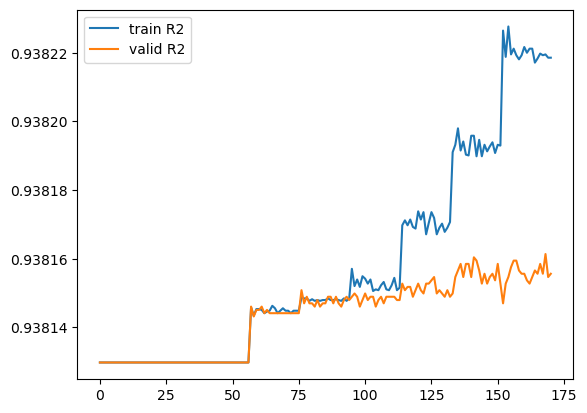

In [95]:
B = np.arange(10,200,10)
D =  np.arange(1,10)
grid = {'n_estimators':B,'max_depth': D}
#Stratify split
rf = RandomForestClassifier()
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(X_train,y_train)

print()
print('         best B =',rfCV.best_params_)
print('  validation R2 =',rfCV.best_score_)

results = pd.DataFrame()
results['train R2'] = rfCV.cv_results_['mean_train_score']
results['valid R2']  = rfCV.cv_results_['mean_test_score']
print(rfCV.score(X_test,y_test))
results.plot.line(y=['train R2','valid R2'])

<Axes: >

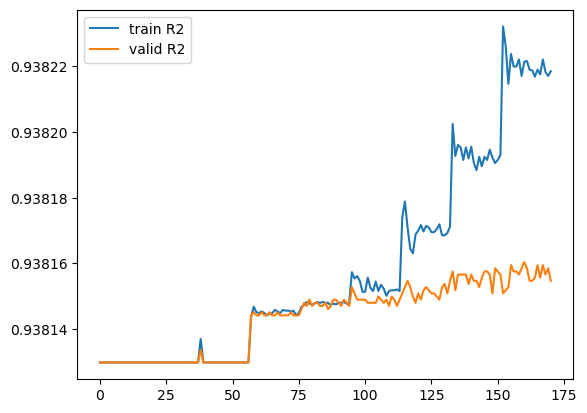

In [90]:
results.plot.line(y=['train R2','valid R2'])

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



         best B = {'max_depth': 9, 'n_estimators': 100}
  validation R2 = 0.6535546432768078


<Axes: >

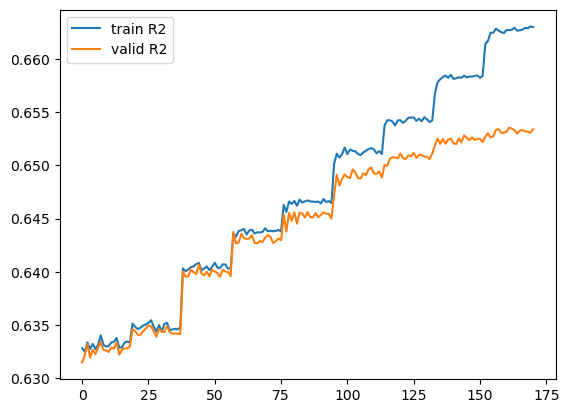

In [91]:
B = np.arange(10,200,10)
D =  np.arange(1,10)
grid = {'n_estimators':B,'max_depth': D}
#Stratify split
rf = RandomForestClassifier()
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(X_downsample,y_downsample)

print()
print('         best B =',rfCV.best_params_)
print('  validation R2 =',rfCV.best_score_)

results2 = pd.DataFrame()
results2['train R2'] = rfCV.cv_results_['mean_train_score']
results2['valid R2']  = rfCV.cv_results_['mean_test_score']
results2.plot.line(y=['train R2','valid R2'])

In [94]:
rfCV.score(X_test,y_test)

0.7071566657096373


         best B = {'max_depth': 9, 'n_estimators': 140}
  validation R2 = 0.6583577232558231


<Axes: >

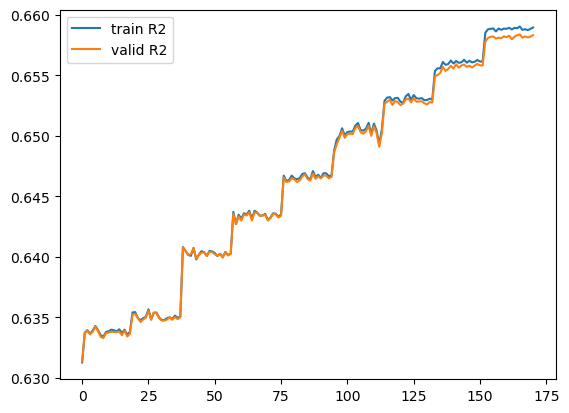

In [96]:
B = np.arange(10,200,10)
D =  np.arange(1,10)
grid = {'n_estimators':B,'max_depth': D}
#Stratify split
rf = RandomForestClassifier()
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(X_upsample,y_upsample)

print()
print('         best B =',rfCV.best_params_)
print('  validation R2 =',rfCV.best_score_)

results2 = pd.DataFrame()
results2['train R2'] = rfCV.cv_results_['mean_train_score']
results2['valid R2']  = rfCV.cv_results_['mean_test_score']
results2.plot.line(y=['train R2','valid R2'])

In [59]:
# #undersampling and oversampling
# B = np.arange(10,200,10)
# D =  np.arange(1,10)
# grid = {'n_estimators':B,'max_depth': D}
# #Stratify split
# rf = RandomForestClassifier()
# X = preprocessing.StandardScaler().fit(X).transform(X)
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
# sss.get_n_splits(X, y)
# scores = [];
# for train_index, test_index in sss.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
#     rfCV.fit(X_train,y_train)
#     pred = rfCV.predict(X_test)
#     scores.append(accuracy_score(y_test, pred))
#     print()
#     print('         best B =',rfCV.best_params_)
#     print('  Accuracy =',rfCV.best_score_.round(3))
# # get accuracy of each prediction
# print(scores)

# #undersampling and F1

ValueError: could not convert string to float: 'quebec nationalist see province nation '